## Classification with Python
In this notebook we try to practice all the classification algorithms that we learned in this course.
We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.
Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset
This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-03-07 08:11:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-03-07 08:11:35 (9.85 MB/s) - ‘loan_train.csv’ saved [23101/23101]



## Load Data From CSV File

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

#### Convert to date time object

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Data visualization and pre-processing
Let’s see how many of each class is in our data set

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         156 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    seaborn-0.10.0             |             py_0         161 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following packages will be UPDATED:

    ca-certificates: 2019.11.27-0       --> 2020.1.1-0        anaconda
    certifi:         2019.11.28-py36_0  --> 2019.11.28-py36_0 anaconda
    openssl:         1.1.1d-h7b6447c_3  --> 1.1.1-h7b6447c_0  anaconda
    seaborn:         0.9.0-pyh91

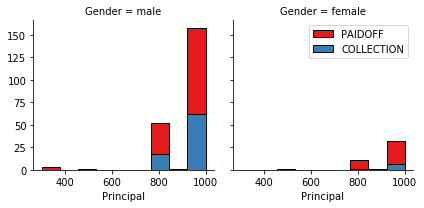

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

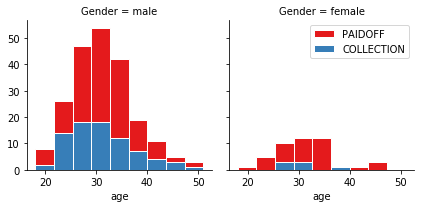

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k", edgecolor="White")

g.axes[-1].legend()
plt.show()

## Pre-processing: Feature selection/extraction
Lets look at the day of the week people get the loan

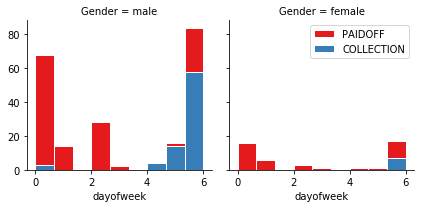

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k", edgecolor="White")
g.axes[-1].legend()
plt.show()

Now we see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values
Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86.54 % of female pay there loans while only 73.13 % of males pay there loan

Lets convert male to 0 and female to 1:

In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding
How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


## Feature selection
Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data
Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [ ]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification
Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model You should use the following algorithm:

. K Nearest Neighbor(KNN)
. Decision Tree
. Support Vector Machine
. Logistic Regression

###  Notice:

. You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
. You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
. You should include the code of the algorithm in the following cells.

## K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.
warning: You should not use the loan_test.csv for finding the best k, however, you can split your train_loan.csv into train and test to find the best k.

In [ ]:
#split dataset to two subsets for training and testing
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=4)
print("Train set:",x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks=20 #test k values from 1 to 20
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    #Modeling use training set and predict
    neigh =KNeighborsClassifier(n_neighbors=n).fit(x_train,y_train)
    y_hat1=neigh.predict(x_test)
    mean_acc[n-1]= metrics.accuracy_score(y_test,y_hat1)
    
    std_acc[n-1]=np.std(y_hat1==y_test)/np.sqrt(y_hat1.shape[0])
mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       , 0.68571429,
       0.72857143, 0.72857143, 0.72857143, 0.7       ])

The best accuracy was with 0.7857142857142857 wirh k= 7


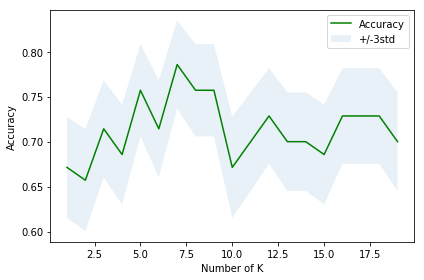

In [ ]:
#plot model accuracy for different Ks
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc-1*std_acc,mean_acc+1*std_acc, alpha=0.1)
plt.legend(('Accuracy','+/-3std'))
plt.ylabel('Accuracy')
plt.xlabel('Number of K')
plt.tight_layout()
plt.show

print("The best accuracy was with", mean_acc.max(),"wirh k=", mean_acc.argmax()+1)

In [ ]:
# use the best k=7 to re-fit the model and calculate training and testing accuracies
neighbest =KNeighborsClassifier(n_neighbors=n).fit(x_train,y_train)
y_hat_train=neighbest.predict(x_train)
y_hat_test=neighbest.predict(x_test)
print("KNN train set accuracy:", metrics.accuracy_score(y_train,y_hat_train))
print("KNN test set accuracy:", metrics.accuracy_score(y_test,y_hat_test))

KNN train set accuracy: 0.7572463768115942
KNN test set accuracy: 0.7


# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

#Modeling using training set 
Tree_model=DecisionTreeClassifier(criterion="entropy",max_depth=4)
Tree_model.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [ ]:
#prediction using testing set
y_hat2=Tree_model.predict(x_test)
print(y_hat2[0:5])
print(y_test[0:5])

['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [ ]:
#evaluate the accuracy of the prediction 
print("Decision Tree Model Train Set Accuracy:",metrics.accuracy_score(y_train,Tree_model.predict(x_train)))
print("Decision Tree Model Test Set Accuracy:",metrics.accuracy_score(y_test,y_hat2))

Decision Tree Model Train Set Accuracy: 0.7463768115942029
Decision Tree Model Test Set Accuracy: 0.6142857142857143


# Support Vector Machine

In [ ]:
# modeling using training set
from sklearn import svm
clf=svm.SVC(kernel='rbf')
clf.fit(x_train,y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [ ]:
#prediction using testing set
y_hat3=clf.predict(x_test)
y_hat3[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [ ]:
#evaluate the accuracy of the prediction 
print("SVM Model Train Set Accuracy:",metrics.accuracy_score(y_train,clf.predict(x_train)))
print("SVM Model Test Set Accuracy:",metrics.accuracy_score(y_test,y_hat3))

SVM Model Train Set Accuracy: 0.782608695652174
SVM Model Test Set Accuracy: 0.7428571428571429


# Logistic Regression Classifier

In [ ]:
#Modeling using training set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR=LogisticRegression(C=0.01,solver='liblinear').fit(x_train,y_train)

In [ ]:
#prediction using testing set
y_hat4=LR.predict(x_test)
y_hat4[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [ ]:
#evaluate the accuracy of the prediction 
print("Logistic Regression Model Train Set Accuracy:",metrics.accuracy_score(y_train,LR.predict(x_train)))
print("Logistic Regression Model Test Set Accuracy:",metrics.accuracy_score(y_test,y_hat4))

Logistic Regression Model Train Set Accuracy: 0.7572463768115942
Logistic Regression Model Test Set Accuracy: 0.6857142857142857


# Model Evaluation using Test set

In [ ]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

Let us, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-03-07 08:14:40--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-03-07 08:14:40 (428 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [ ]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature2 = test_df[['Principal','terms','age','Gender','weekend']]
Feature2 = pd.concat([Feature2,pd.get_dummies(test_df['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
Feature2.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [ ]:
#normalize test data set
x2= preprocessing.StandardScaler().fit(Feature2).transform(Feature2)
y2 = test_df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

In [ ]:
# KNN model testing and accuracy
y2_hat1=neighbest.predict(x2)#prediction
F1_kkn=f1_score(y2,y2_hat1,average='weighted') #F1 Score
jaccard_kkn=jaccard_similarity_score(y2,y2_hat1) #Jaccard index

In [ ]:
# Decision Tree model testing and accuracy
y2_hat2=Tree_model.predict(x2)#prediction
F1_tree=f1_score(y2,y2_hat2,average='weighted') #F1 Score
jaccard_tree=jaccard_similarity_score(y2,y2_hat2) #Jaccard index

In [ ]:
# SVM model testing and accuracy
y2_hat3=clf.predict(x2)#prediction
F1_svm=f1_score(y2,y2_hat3,average='weighted') #F1 Score
jaccard_svm=jaccard_similarity_score(y2,y2_hat3) #Jaccard index

In [ ]:
# Logistic Regression model testing and accuracy
y2_hat4=LR.predict(x2)#prediction
F1_lr=f1_score(y2,y2_hat4,average='weighted') #F1 Score
jaccard_lr=jaccard_similarity_score(y2,y2_hat4) #Jaccard index
#calculate logloss for logistic regression
y2_hat4_prob=LR.predict_proba(x2)
logloss_lr=log_loss(y2,y2_hat4_prob)

### Report the evaluation metrics

In [ ]:
evaluation_data=[['KNN',jaccard_kkn,F1_kkn,'NA'],['Decision Tree',jaccard_tree,F1_tree,'NA'],['SVM',jaccard_svm,F1_svm,'NA'],['Logistic Regression',jaccard_lr,F1_lr,logloss_lr]]
df=pd.DataFrame(evaluation_data,columns=['Algorithm','Jaccard','F1-score','LogLoss'])
df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.740741,0.714431,NA
1,Decision Tree,0.722222,0.736682,NA
2,SVM,0.796296,0.758350,NA
3,Logistic Regression,0.740741,0.660427,0.567215
